In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from mpl_toolkits import mplot3d

from scipy.optimize import curve_fit
from PIL import Image

from scipy.special import softmax
import imageio
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')

In [15]:
def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id], fmt='%i',delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run):
    
    #emb without void node
    
    x=x[1:]
    y=y[1:]
    t=t[1:]
    
    #############
    
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            #A[i,0]=1.5  ####
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=gaus2d(x[j], y[j], x[i], y[i]) #1/((x[i]-x[j])**2+(y[i]-y[j])**2)
            #if i>j:
                #A[i,j]=0
        if np.sum(A[i,:])!=0:
            A[i,:]=mean_normal(A[i,:])
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    
    np.savetxt('./'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt('./'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    
    
    np.savetxt('./node2vec/graph/'+str(run)+'.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt('./'+str(run)+'_GT'+'/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))



def padding(maxlen,run):
    #A,B,E
    
    B=np.loadtxt('./'+str(run)+'/'+'B.txt')
    A=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.txt')
    E=np.loadtxt('./'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
    
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):

def fit_func(x,a,b):
    return a*x+b

def fingerprint_emb(pos_x,pos_y,window,t,run,void_node=True,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747):
    x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
    im = blend(run,t)#Image.open(path).convert('L') # Can be many different formats.
    im_crop = im.crop((x_l, y_l, x_r, y_u))
     
    if t==10 and run==1:
        im_crop.show()
    foo = im_crop.resize((10,10),Image.ANTIALIAS)

    imarray = np.asarray(foo)
    imarray=imarray.flatten()/255
    return imarray



def fingerprint_wrap(window,run,void=False):
    pos_x,pos_y,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',usecols=(0,1,6), unpack=True)
    l=len(pos_x)-1
    
    
    f_e = np.array([np.zeros(100)])


    for k in range(int(np.max(t))+1):
        path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(k)+'.png'
        pos_x_n=pos_x[t==k]
        pos_y_n=pos_y[t==k]
        if k==0:
            pos_x_n=pos_x_n[1:]
            pos_y_n=pos_y_n[1:]
        for j in range(len(pos_x_n)):
            imarray=np.array([fingerprint_emb(pos_x_n[j],pos_y_n[j],window,k,run)])
            f_e=np.concatenate((f_e, imarray), axis=0)
            
    
    if void==False:
        f_e=f_e[1:]
            
        
    return f_e
    
    
def blend(run,t):
    
    
    
    pathm1='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t-1)+'.png'
    path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t)+'.png'
    pathp1='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(t+1)+'.png'
    
    
    im = Image.open(path).convert('L')
    shape = np.asarray(im).shape
    
    #print(pixels.shape)
    try:
        imm1 = Image.open(pathm1).convert('L')
        pixels = np.asarray(imm1)
        #print(pixels)
        pixels = pixels.astype('float32')
        pixels = pixels/2
        #pixels = pixels.astype('int')
        imm1 = Image.fromarray(pixels).convert('L')
    except:
        pix=255*np.ones(shape)
        imm1 = Image.fromarray(pix).convert('L')
        
    try:
        imp1 = Image.open(pathp1).convert('L')
    except:
        pix=255*np.ones(shape)
        imp1 = Image.fromarray(pix).convert('L')
    
    
    
    im3 = Image.blend(imm1, imp1, 0.5)
    im4 = Image.blend(im3, im, 0.5)
    #im4.show()
    return im4
    
    


    
    
    
'''
pos_x=[5.926355409057428858e-01,4.604170197372819962e-01,6.250962551422760416e-02,1.223613241454796496e-01,6.376507269405902179e-01,1.103583087228645621e-01,4.233227679149828004e-01]
pos_y=[5.378065857159227692e-01,5.482527480620434934e-01,1.628245440499290486e-01,8.255699686855265673e-01,5.184511465256566032e-01,1.492480151352687523e-01,5.115442664966730613e-01]
pix_x=[87,72,27,33,92,32,68]
pix_y=[70,69,113,37,72,114,73]


plt.errorbar(pos_y, pix_y,fmt='.')   

popt, pcov = curve_fit(fit_func, pos_y,pix_y)

plt.plot(pos_y, fit_func(np.array(pos_y),*popt))
print(popt)
'''

a_y=-114.14194117
a_x=113.89266922
b_y=131.3404747
b_x=19.51478307
    
def calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window):
    pix_x0=int(fit_func(pos_x,a_x,b_x))
    
    pix_y0=int(fit_func(pos_y,a_y,b_y))
    #print(pix_x0,pix_y0,int(pix_x0-window))
    return int(pix_x0-window),int(pix_x0+window),int(pix_y0-window),int(pix_y0+window)

In [16]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)


A=np.ones((3,4))
B=np.zeros((3,2))
print(np.c_[A, B])
print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))


#A,B,E =padding(7,1)

#print(E)
#blend(10)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.34564343  0.4228358   0.83579415 ...  1.          1.
   1.        ]
 [-0.45608157  0.11756085  0.20810717 ...  1.          1.
   1.        ]
 ...
 [ 0.41631582 -0.0660716   0.14245771 ...  0.74117647  0.81176471
   0.77647059]
 [ 0.19548158 -0.1464654  -0.07056799 ...  0.8745098   0.8745098
   0.8745098 ]
 [ 0.38638848  0.29515862 -0.1725945  ...  0.8745098   0.8745098
   0.8745098 ]]
[[1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 0.]]
1.2720668358645384


In [17]:
lenA=[]
for i in range(1,15):

    run=i

    x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
    #print(len(x))
    A=make_adjacency(x,y,r,t,ide,split_id,run)
    print(len(A),i)
    lenA.append(len(A))
    
    B=make_weighted_adj_estimate(x,y,t,run)
    #print(B)
    C,e1,e2,w=make_weighted_edgelist(B,run)
    make_true_edgelist(A,run)
    
    make_dist_matrix(x,y,t,run)
    
maxlen=np.max(lenA)
print(maxlen)






243 1
244 2
217 3
236 4
231 5
231 6
269 7
240 8
239 9
253 10
211 11
237 12
224 13
242 14
269


In [18]:
#print(stop)

for i in range(1,15):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)
    

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    
    ####
    b=np.concatenate((np.array([np.zeros(len(b[0]))]), b), axis=0) #######if void node not included in n2v
    ####
    
    
    f_e=fingerprint_wrap(20,run,void=True)  #always 000000000000000 for fingerprint
    b=np.c_[b, f_e]
    #print(len(f_e),run)
    
    #pos_x,pos_y= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',, unpack=True)
    #id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b[0]),run)
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    #padding(maxlen,run)
    

150 1
150 2
150 3
150 4
150 5
150 6
150 7
150 8
150 9
150 10
150 11
150 12
150 13
150 14


python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

In [ ]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

<IPython.core.display.Javascript object>


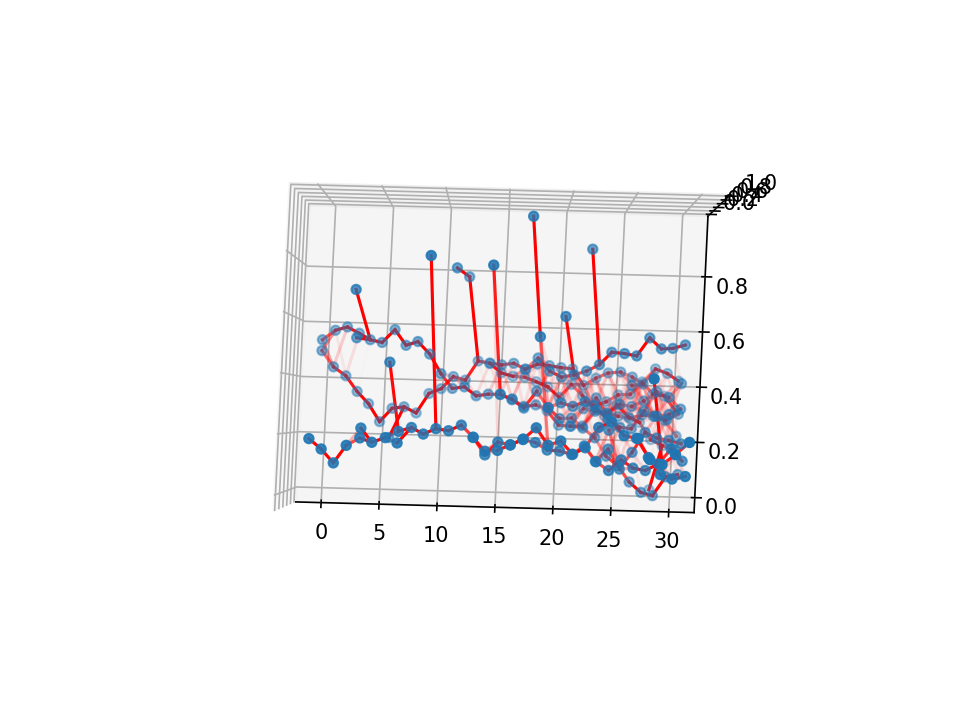

1.0 4.0
[0.32775551102204403, 0.2914265945638689]
1.0 5.0
[0.32775551102204403, 0.30771677961147614]
2.0 4.0
[0.32775551102204403, 0.2914265945638689]
2.0 5.0
[0.32775551102204403, 0.30771677961147614]
3.0 6.0
[0.8489979959919839, 0.8392142645956335]
4.0 8.0
[0.2914265945638689, 0.3048052322655071]
4.0 9.0
[0.2914265945638689, 0.24830416291662186]
5.0 8.0
[0.30771677961147614, 0.3048052322655071]
5.0 9.0
[0.30771677961147614, 0.24830416291662186]
6.0 7.0
[0.8392142645956335, 0.8234780636174227]
7.0 13.0
[0.8234780636174227, 0.8595538113656539]
8.0 10.0
[0.3048052322655071, 0.2977346614574955]
8.0 12.0
[0.3048052322655071, 0.47695390781563124]
9.0 10.0
[0.24830416291662186, 0.2977346614574955]
9.0 14.0
[0.24830416291662186, 0.24243392407881162]
10.0 18.0
[0.2977346614574955, 0.35529340154019556]
11.0 18.0
[0.6973947895791582, 0.35529340154019556]
12.0 18.0
[0.47695390781563124, 0.35529340154019556]
13.0 15.0
[0.8595538113656539, 0.811558466360505]
13.0 16.0
[0.8595538113656539, 0.767535

116.0 127.0
[0.2223185114699901, 0.1579029800507601]
116.0 128.0
[0.2223185114699901, 0.23582418534977892]
116.0 131.0
[0.2223185114699901, 0.013381690729654339]
116.0 132.0
[0.2223185114699901, 0.32300015921696223]
116.0 133.0
[0.2223185114699901, 0.3651222715878238]
117.0 124.0
[0.47122694962762235, 0.516119386815131]
117.0 129.0
[0.47122694962762235, 0.45870746086947434]
117.0 132.0
[0.47122694962762235, 0.32300015921696223]
118.0 125.0
[0.3279000879785165, 0.12919078409479282]
118.0 128.0
[0.3279000879785165, 0.23582418534977892]
118.0 129.0
[0.3279000879785165, 0.45870746086947434]
118.0 132.0
[0.3279000879785165, 0.32300015921696223]
118.0 133.0
[0.3279000879785165, 0.3651222715878238]
119.0 123.0
[0.7748638735552644, 0.7787296839584283]
119.0 126.0
[0.7748638735552644, 0.6627181036351842]
119.0 130.0
[0.7748638735552644, 0.5667596317110472]
120.0 125.0
[0.06449860304931529, 0.12919078409479282]
120.0 127.0
[0.06449860304931529, 0.1579029800507601]
120.0 128.0
[0.0644986030493152

160.0 173.0
[0.23046092184368736, 0.36055586076371543]
160.0 176.0
[0.23046092184368736, 0.19283574434715467]
160.0 181.0
[0.23046092184368736, 0.2852177343340663]
161.0 173.0
[0.3558064343215472, 0.36055586076371543]
161.0 175.0
[0.3558064343215472, 0.5126932454531609]
161.0 176.0
[0.3558064343215472, 0.19283574434715467]
161.0 177.0
[0.3558064343215472, 0.3920201822408892]
161.0 181.0
[0.3558064343215472, 0.2852177343340663]
162.0 170.0
[0.6590323640889092, 0.8493409061833485]
162.0 175.0
[0.6590323640889092, 0.5126932454531609]
162.0 180.0
[0.6590323640889092, 0.6593407573054044]
163.0 170.0
[0.9549546539536147, 0.8493409061833485]
163.0 179.0
[0.9549546539536147, 0.9939879759519037]
163.0 182.0
[0.9549546539536147, 0.9662659490014179]
164.0 173.0
[0.5158632993622452, 0.36055586076371543]
164.0 175.0
[0.5158632993622452, 0.5126932454531609]
164.0 177.0
[0.5158632993622452, 0.3920201822408892]
164.0 180.0
[0.5158632993622452, 0.6593407573054044]
165.0 171.0
[0.28730106482976386, 0.16

207.0 211.0
[0.3515046755929625, 0.34490269223911485]
207.0 212.0
[0.3515046755929625, 0.367469878339689]
207.0 221.0
[0.3515046755929625, 0.2335539812639783]
208.0 216.0
[0.6625151564766214, 0.5032700893482901]
208.0 217.0
[0.6625151564766214, 0.6112457200275203]
208.0 223.0
[0.6625151564766214, 0.8438648908965903]
209.0 210.0
[0.041688785294635544, 0.1562239807908352]
209.0 214.0
[0.041688785294635544, 0.08469254190921524]
209.0 218.0
[0.041688785294635544, -0.02849646730606321]
209.0 222.0
[0.041688785294635544, 0.015746449255721807]


In [7]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=13

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)



x=x[1:]
y=y[1:]
t=t[1:]

#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    ax.plot3D(tline, yline, xline, c='red',alpha=w[i]/100)
    #ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

#plt.savefig('./TimeGraph.png',dpi=my_dpi,transparent=False) 

In [ ]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        print('ii',ii)
        print(prev_c)
        return prev_c[int(ii-2)],False
    if id1==1:
        return 'black',True
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0],False
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id=id[1:]
tt=tt[1:]
id_f=[2,3,4]


print(c[id_f==1])


    


for t in range(31):
    
        
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf,rec=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        if rec:
            rec1=plt.Rectangle((x_n,y_n), r_n, r_n,fc=c_cf,ec=c_cf) 
            ax.add_patch(rec1)
        else:
            circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
            ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)